
# 📊 TelecomX - Análisis Churn de Clientes

### 0) Importación de Librerías y Configuración del Entorno

In [9]:
# @title
# -------------------------
# 0) Importar librerías
# -------------------------
import warnings
warnings.filterwarnings("ignore")

import os
import re
import json
import locale
from textwrap import dedent

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Plotly (opcional para algunos gráficos interactivos)
try:
    import plotly.express as px
    PLOTLY_OK = True
except Exception:
    PLOTLY_OK = False

# Configuración visual y regional en español (si está disponible)
for loc in ("es_CO.utf8","es_CO","es_ES.utf8","es_ES","es_MX.utf8","es_MX"):
    try:
        locale.setlocale(locale.LC_ALL, loc)
        break
    except Exception:
        pass

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}".replace(",", "X").replace(".", ",").replace("X", "."))

sns.set(style="whitegrid")
np.random.seed(42)

print("✅ Entorno listo.")

✅ Entorno listo.


### 1) Definición de URL y Funciones de Apoyo

In [10]:
# @title
# ---------------------------------------------------------
# 1) URL RAW de tu GitHub (JSON)
# ---------------------------------------------------------
RAW_URL = "https://raw.githubusercontent.com/Alxs68/TelecomX_LATAM/main/TelecomX_Data.json"


# ---------------------------------------------------------
# 2) Funciones sencillas de apoyo (estilo principiante)
# ---------------------------------------------------------

def leer_desde_url(url):
    """
    Lee un JSON desde una URL RAW de GitHub y devuelve un DataFrame normalizado.
    """
    nombre = url.lower()
    if nombre.endswith(".json"):
        # Lectura JSON simple
        try:
            # Use json_normalize for nested structures
            resp = requests.get(url, timeout=30)
            resp.raise_for_status()
            data = resp.json()
            df = pd.json_normalize(data, sep=".")
            return df
        except Exception as e:
            raise ValueError(f"Error al leer o normalizar JSON: {e}")
    else:
        raise ValueError("Formato de URL no soportado. Se espera un archivo JSON.")


def normalizar_columna(nombre):
    """
    Pasa el nombre de columna a mayúsculas y reemplaza espacios por guion bajo y puntos.
    """
    s = str(nombre).strip()
    s = re.sub(r"\s+", "_", s)
    s = s.replace("%", "pct")
    s = s.replace(".", "_") # Reemplazar puntos por guiones bajos
    return s.upper()


# Diccionario para traducir nombres de columnas (inglés → español)
# (Si ya vienen en español, solo se normalizan a MAYUS_CON_GUION)
TRAD_COLS = {
    "CUSTOMERID": "ID_CLIENTE",
    "GENDER": "GENERO",
    "SENIORCITIZEN": "ADULTO_MAYOR",
    "PARTNER": "PAREJA",
    "DEPENDENTS": "DEPENDIENTES",
    "TENURE": "ANTIGUEDAD_MESES",
    "PHONESERVICE": "SERVICIO_TELEFONICO",
    "MULTIPLELINES": "LINEAS_MULTIPLES",
    "INTERNETSERVICE": "TIPO_INTERNET",
    "ONLINESECURITY": "SEGURIDAD_EN_LINEA",
    "ONLINEBACKUP": "RESPALDO_EN_LINEA",
    "DEVICEPROTECTION": "PROTECCION_DISPOSITIVO",
    "TECHSUPPORT": "SOPORTE_TECNICO",
    "STREAMINGTV": "STREAMING_TV",
    "STREAMINGMOVIES": "STREAMING_PELICULAS",
    "CONTRACT": "TIPO_CONTRATO",
    "PAPERLESSBILLING": "FACTURACION_ELECTRONICA",
    "PAYMENTMETHOD": "METODO_PAGO",
    "MONTHLYCHARGES": "CARGO_MENSUAL",
    "TOTALCHARGES": "CARGO_TOTAL",
    "CHURN": "CHURN",   # dejamos CHURN tal cual como nombre objetivo
    "MONTHLY_CHARGES": "CARGO_MENSUAL",
    "TOTAL_CHARGES": "CARGO_TOTAL",
    # Añadir las claves con la estructura anidada normalizada si es necesario,
    # o asegurar que normalizar_columna mapea a las claves existentes.
    # Con la modificación en normalizar_columna para reemplazar '.',
    # nombres como 'CUSTOMER_GENDER' deberían ahora coincidir con 'GENDER' si la key existe.
    # Sin embargo, las keys en TRAD_COLS no tienen la estructura anidada.
    # Deberíamos actualizar TRAD_COLS para que coincida con la salida de normalizar_columna.
    # O, mejor, ajustar la lógica para que busque en TRAD_COLS usando solo la última parte del nombre.
    # Por simplicidad, ajustaremos TRAD_COLS para que coincida con la salida esperada de normalizar_columna con '.' reemplazado por '_'.
    "CUSTOMER_GENDER": "GENERO",
    "CUSTOMER_SENIORCITIZEN": "ADULTO_MAYOR",
    "CUSTOMER_PARTNER": "PAREJA",
    "CUSTOMER_DEPENDENTS": "DEPENDIENTES",
    "CUSTOMER_TENURE": "ANTIGUEDAD_MESES",
    "PHONE_PHONESERVICE": "SERVICIO_TELEFONICO",
    "PHONE_MULTIPLELINES": "LINEAS_MULTIPLES",
    "INTERNET_INTERNETSERVICE": "TIPO_INTERNET",
    "INTERNET_ONLINESECURITY": "SEGURIDAD_EN_LINEA",
    "INTERNET_ONLINEBACKUP": "RESPALDO_EN_LINEA",
    "INTERNET_DEVICEPROTECTION": "PROTECCION_DISPOSITIVO",
    "INTERNET_TECHSUPPORT": "SOPORTE_TECNICO",
    "INTERNET_STREAMINGTV": "STREAMING_TV",
    "INTERNET_STREAMINGMOVIES": "STREAMING_PELICULAS",
    "ACCOUNT_CONTRACT": "TIPO_CONTRATO",
    "ACCOUNT_PAPERLESSBILLING": "FACTURACION_ELECTRONICA",
    "ACCOUNT_PAYMENTMETHOD": "METODO_PAGO",
    "ACCOUNT_CHARGES_MONTHLY": "CARGO_MENSUAL",
    "ACCOUNT_CHARGES_TOTAL": "CARGO_TOTAL",
}


# Traducción de valores típicos (solo etiquetas visuales)
TRAD_VALORES = {
    "Male": "Hombre",
    "Female": "Mujer",
    "Yes": "Si",
    "No": "No",
    "No internet service": "Sin internet",
    "DSL": "DSL",
    "Fiber optic": "Fibra óptica",
    "Month-to-month": "Mes a mes",
    "One year": "Un año",
    "Two year": "Dos años",
    "Electronic check": "Cheque electrónico",
    "Mailed check": "Cheque por correo",
    "Bank transfer (automatic)": "Transferencia bancaria (automática)",
    "Credit card (automatic)": "Tarjeta de crédito (automática)"
}


def traducir_dataframe_es(df):
    """
    Renombra columnas a español y traduce valores comunes en categóricas.
    DESDE AQUÍ EN ADELANTE se usan SOLO estos nombres en español.
    """
    df2 = df.copy()

    # Renombrar columnas
    renombrar = {}
    for c in df2.columns:
        c_norm = normalizar_columna(c)
        if c_norm in TRAD_COLS:
            renombrar[c] = TRAD_COLS[c_norm]
        else:
            # Si no está en TRAD_COLS, usamos el nombre normalizado
            renombrar[c] = c_norm
    df2 = df2.rename(columns=renombrar)

    # Traducir valores categóricos simples
    for c in df2.columns:
        if df2[c].dtype == "object":
            # Ensure the values are strings before applying replace
            # Check if any value in the column is a string before applying .str accessor
            # Use .replace() for mapping values using a dictionary, not .str.replace()
            df2[c] = df2[c].astype(str).replace(TRAD_VALORES)


    return df2


def convertir_numericos_basicos(df, lista_patrones):
    """
    Convierte a numérico columnas que contengan los patrones indicados.
    Reemplaza coma decimal por punto y quita separador de miles.
    """
    for c in df.columns:
        for patron in lista_patrones:
            if re.search(patron, c, flags=re.I):
                try:
                    s = df[c].astype(str)
                    s = s.str.replace(r"\s", "", regex=True)
                    s = s.str.replace(".", "", regex=False)   # elimina miles
                    s = s.str.replace(",", ".", regex=False)   # coma → punto
                    df[c] = pd.to_numeric(s, errors="coerce")
                except Exception:
                    pass
                break
    return df


def crear_churn_flag(df, col_target):
    """
    Crea CHURN_FLAG (0/1) sin imputar faltantes.
    - Mapea Si/No/Yes/No/1/0 a 1/0 cuando es posible.
    - Si no se puede, deja NaN.
    """
    if col_target is None or col_target not in df.columns:
        return df

    mapa = {
        "Si": 1, "SÍ":1, "Sí":1, "SI":1, "si":1, "sí":1, "Yes":1, "YES":1, "yes":1, "1":1, 1:1,
        "No": 0, "NO":0, "no":0, "N":0, "n":0, "False":0, "false":0, "0":0, 0:0
    }

    serie = df[col_target].copy()
    df["CHURN_FLAG"] = serie.map(mapa)

    # Si sigue raro pero son solo 0/1 como texto o número, lo convertimos
    sin_na = serie.dropna().unique().tolist()
    conjunto = set([str(v) for v in sin_na])
    if conjunto.issubset({"0","1"}):
        try:
            df["CHURN_FLAG"] = pd.to_numeric(serie, errors="coerce")
        except Exception:
            pass

    # NO imputamos faltantes de CHURN_FLAG
    return df

# Funciones de métricas simples
def correlacion_binaria_numerica(y_bin, x_num):
    """
    Correlación simple entre binaria (0/1) y numérica.
    - Ignora pares con NaN.
    - Devuelve NaN si no hay suficientes datos o no hay 0/1.
    (Es una aproximación simple para principiantes)
    """
    tmp = pd.concat([y_bin, x_num], axis=1).dropna()
    if tmp.shape[0] < 5:
        return np.nan
    valores = set(tmp[y_bin.name].unique())
    if not valores.issubset({0,1}):
        return np.nan
    try:
        # Ensure both columns are numeric before calculating correlation
        r = tmp[y_bin.name].astype(float).corr(tmp[x_num.name].astype(float))
        return float(r)
    except Exception:
        return np.nan

def cramers_v_simple(cat, y_bin):
    """
    V de Cramér entre categórica y binaria (implementación simple).
    Devuelve un indicador entre 0 y 1 (mayor = más asociación).
    """
    tmp = pd.concat([cat, y_bin], axis=1).dropna()
    if tmp.shape[0] == 0:
        return np.nan

    # Ensure the categorical column is treated as string for crosstab
    tabla = pd.crosstab(tmp.iloc[:,0].astype(str), tmp.iloc[:,1])  # filas=cat, columnas=bin
    n = tabla.values.sum()
    if n == 0:
        return np.nan

    fila_sum = tabla.sum(axis=1).values.reshape(-1,1)
    col_sum = tabla.sum(axis=0).values.reshape(1,-1)
    esperados = (fila_sum @ col_sum) / n
    obs = tabla.values.astype(float)

    mascara = esperados > 0
    chi2 = ((obs[mascara] - esperados[mascara])**2 / esperados[mascara]).sum()

    r = tabla.shape[0]
    k = tabla.shape[1]
    denom = min(r-1, k-1)
    if denom <= 0:
        return np.nan
    v = (chi2 / n) ** 0.5 / (denom ** 0.5)
    return float(v)

def eta2_cat_num_simple(cat, num):
    """
    Eta cuadrado (η²) para ver cuánto explica una categórica a una numérica.
    Se usa como contexto adicional.
    """
    tmp = pd.concat([cat, num], axis=1).dropna()
    if tmp.shape[0] == 0:
        return np.nan

    # Ensure the categorical column is treated as string for groupby
    grupos = tmp.groupby(tmp.columns[0])[tmp.columns[1]]
    media_global = tmp.iloc[:,1].mean()
    ss_between = 0.0
    ss_total = 0.0

    for g, serie in grupos:
        n_g = len(serie)
        media_g = serie.mean()
        ss_between += n_g * (media_g - media_global) ** 2

    ss_total = ((tmp.iloc[:,1] - media_global) ** 2).sum()

    if ss_total == 0:
        return np.nan

    return float(ss_between / ss_total)


## 🧹 Normalización final de nombres en **español**
Para garantizar uniformidad total en las columnas (y que todos los gráficos/etiquetas queden en español),
aplicamos un renombrado **no intrusivo** que solo cambia nombres si existen columnas en inglés o mixtas.


In [11]:
# @title

# === BLOQUE DE MEJORA: Normalización final de nombres a ESPAÑOL ===
# Nota: No modifica la lógica ni los datos, solo uniforma etiquetas/columnas.

def _normalizar_nombre(c):
    import re
    s = str(c).strip()
    s = re.sub(r"\s+", "_", s)
    s = s.replace("%", "pct")
    return s.upper()

# Mapeos directos EN->ES para columnas típicas que a veces quedan sin traducir
_MAP_COLS_ES = {
    "INTERNETSERVICE": "TIPO_INTERNET",
    "TOTALCHARGES": "CARGO_TOTAL",
    "MONTHLYCHARGES": "CARGO_MENSUAL",
    "CUSTOMERID": "ID_CLIENTE",
    "GENDER": "GENERO",
    "SENIORCITIZEN": "ADULTO_MAYOR",
    "PAYMENTMETHOD": "METODO_PAGO",
    "CONTRACT": "TIPO_CONTRATO",
    "PAPERLESSBILLING": "FACTURACION_ELECTRONICA",
    "STREAMINGTV": "STREAMING_TV",
    "STREAMINGMOVIES": "STREAMING_PELICULAS",
    "TECHSUPPORT": "SOPORTE_TECNICO",
    "DEVICEPROTECTION": "PROTECCION_DISPOSITIVO",
    "ONLINEBACKUP": "RESPALDO_EN_LINEA",
    "ONLINESECURITY": "SEGURIDAD_EN_LINEA",
    "PHONESERVICE": "SERVICIO_TELEFONICO",
    "MULTIPLELINES": "LINEAS_MULTIPLES",
    "TENURE": "ANTIGUEDAD_MESES",
    "TOTAL_CHARGES": "CARGO_TOTAL",
    "MONTHLY_CHARGES": "CARGO_MENSUAL",
    # Variantes frecuentes
    "INTERNET_SERVICE": "TIPO_INTERNET",
    "TOTAL_CHARGE": "CARGO_TOTAL",
    "MONTHLY_CHARGE": "CARGO_MENSUAL"
}

# Si existen columnas derivadas con prefijos en inglés tipo 'INTERNET_...' las pasamos a español
_COMPONENTES_INTERNET = {
    "ONLINESECURITY": "SEGURIDAD_EN_LINEA",
    "ONLINE_BACKUP": "RESPALDO_EN_LINEA",
    "ONLINEBACKUP": "RESPALDO_EN_LINEA",
    "DEVICEPROTECTION": "PROTECCION_DISPOSITIVO",
    "TECHSUPPORT": "SOPORTE_TECNICO",
    "STREAMINGTV": "STREAMING_TV",
    "STREAMINGMOVIES": "STREAMING_PELICULAS"
}

def _mapear_componentes(col):
    base = col
    # estandarizamos
    base = _normalizar_nombre(base)
    # Si empieza por INTERNET_ o similares
    if base.startswith("INTERNET_"):
        suf = base.replace("INTERNET_", "")
        # traducciones directas
        if suf in _COMPONENTES_INTERNET:
            return "INTERNET_" + _COMPONENTES_INTERNET[suf]
        # si ya está en español o no conocido, mantenemos base
        return base
    return base

def normalizar_columnas_es(df):
    cols_new = {}
    for c in df.columns:
        cn = _normalizar_nombre(c)
        # 1) aplicar mapeo directo si corresponde
        if cn in _MAP_COLS_ES:
            cols_new[c] = _MAP_COLS_ES[cn]
            continue
        # 2) aplicar regla para INTERNET_* derivados
        mapped = _mapear_componentes(cn)
        cols_new[c] = mapped
    return df.rename(columns=cols_new)

# Aplicar si existe 'df' en el entorno
try:
    _cols_before = list(df.columns)
    df = normalizar_columnas_es(df)
    _cols_after = list(df.columns)
    print("✅ Normalización ES aplicada. Cambios de nombre (si hubo):")
    cambios = [(a,b) for a,b in zip(_cols_before, _cols_after) if a!=b]
    for a,b in cambios[:20]:
        print(f"  - {a}  ->  {b}")
    if len(cambios) > 20:
        print(f"  ... y {len(cambios)-20} cambios más.")
except NameError:
    print("ℹ️ Nota: no encontré 'df' aún. Ejecuta este bloque después de crear el DataFrame 'df'.")


✅ Normalización ES aplicada. Cambios de nombre (si hubo):


### 2) Carga, Traducción y Limpieza Básica del DataFrame

In [12]:
# @title
# ---------------------------------------------------------
# 3) Carga + Traducción + Limpieza básica
# ---------------------------------------------------------
# Need requests for leer_desde_url
import requests

df_raw = leer_desde_url(RAW_URL)
print("✅ Datos cargados desde GitHub:", df_raw.shape)
display(df_raw.head(3))

df = traducir_dataframe_es(df_raw)
print("✅ DataFrame traducido a español (columnas y etiquetas).")
display(df.head(3))

# Identificar columna objetivo (CHURN / BAJA / CANCELADO / TARGET)
candidatas = ["CHURN","BAJA","CANCELADO","TARGET"]
col_target = None
for c in df.columns:
    if c.upper() in candidatas:
        col_target = c
        break
if col_target is None:
    # búsqueda por nombre que contenga "CHURN"
    for c in df.columns:
        if "CHURN" in c.upper():
            col_target = c
            break

print("🎯 Columna objetivo detectada:", col_target if col_target else "No detectada")

# Convertir a numérico algunas columnas típicas (economía y conteo)
patrones_num = ["ANTIGUEDAD", "CARGO", "TOTAL", "MONTO", "VALOR", "PAGO", "INGRESO", "MESES", "QTY", "CANT"]
df = convertir_numericos_basicos(df, patrones_num)

# Normalizar texto en categóricas (trim) - Apply only to columns that are actually strings after normalization
for c in df.columns:
    # Check if the column is of object type and contains strings
    if df[c].dtype == "object" and df[c].apply(lambda x: isinstance(x, str)).all():
        df[c] = df[c].str.strip()
    elif df[c].dtype == "object":
        # If not all values are strings, convert to string before stripping
        df[c] = df[c].astype(str).str.strip()


# Crear CHURN_FLAG (sin imputar faltantes)
df = crear_churn_flag(df, col_target)

print("✅ Limpieza básica completa.")
print("Columnas (español):", list(df.columns))

✅ Datos cargados desde GitHub: (7267, 21)


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,"65,6000",593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,"59,9000",542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,"73,9000",280.85


✅ DataFrame traducido a español (columnas y etiquetas).


,ID_CLIENTE,CHURN,GENERO,ADULTO_MAYOR,PAREJA,DEPENDIENTES,ANTIGUEDAD_MESES,SERVICIO_TELEFONICO,LINEAS_MULTIPLES,TIPO_INTERNET,SEGURIDAD_EN_LINEA,RESPALDO_EN_LINEA,PROTECCION_DISPOSITIVO,SOPORTE_TECNICO,STREAMING_TV,STREAMING_PELICULAS,TIPO_CONTRATO,FACTURACION_ELECTRONICA,METODO_PAGO,CARGO_MENSUAL,CARGO_TOTAL
0,0002-ORFBO,No,Mujer,0,Si,Si,9,Si,No,DSL,No,Si,No,Si,Si,No,Un año,Si,Cheque por correo,"65,6000",593.3
1,0003-MKNFE,No,Hombre,0,No,No,9,Si,Si,DSL,No,No,No,No,No,Si,Mes a mes,No,Cheque por correo,"59,9000",542.4
2,0004-TLHLJ,Si,Hombre,0,No,No,4,Si,No,Fibra óptica,No,No,Si,No,No,No,Mes a mes,Si,Cheque electrónico,"73,9000",280.85


🎯 Columna objetivo detectada: CHURN
✅ Limpieza básica completa.
Columnas (español): ['ID_CLIENTE', 'CHURN', 'GENERO', 'ADULTO_MAYOR', 'PAREJA', 'DEPENDIENTES', 'ANTIGUEDAD_MESES', 'SERVICIO_TELEFONICO', 'LINEAS_MULTIPLES', 'TIPO_INTERNET', 'SEGURIDAD_EN_LINEA', 'RESPALDO_EN_LINEA', 'PROTECCION_DISPOSITIVO', 'SOPORTE_TECNICO', 'STREAMING_TV', 'STREAMING_PELICULAS', 'TIPO_CONTRATO', 'FACTURACION_ELECTRONICA', 'METODO_PAGO', 'CARGO_MENSUAL', 'CARGO_TOTAL', 'CHURN_FLAG']


### 3) Calidad de Datos y Vistazo General

👀 Filas: 7267 | Columnas: 22
🧬 Tipos de datos:


,tipo
ID_CLIENTE,object
CHURN,object
GENERO,object
ADULTO_MAYOR,int64
PAREJA,object
DEPENDIENTES,object
ANTIGUEDAD_MESES,int64
SERVICIO_TELEFONICO,object
LINEAS_MULTIPLES,object
TIPO_INTERNET,object


📉 Nulos por columna (Top 15):


,0
METODO_PAGO,"100,0000"
CHURN_FLAG,"3,0800"
CARGO_TOTAL,"0,1500"
GENERO,"0,0000"
ID_CLIENTE,"0,0000"
CHURN,"0,0000"
DEPENDIENTES,"0,0000"
PAREJA,"0,0000"
ADULTO_MAYOR,"0,0000"
ANTIGUEDAD_MESES,"0,0000"


📊 Distribución de la columna objetivo (tal cual):


,count
CHURN,
No,5174
Si,1869
,224


📊 Distribución de CHURN_FLAG (0/1) [NaN se mantienen]:


,count
CHURN_FLAG,
"0,0000",5174
"1,0000",1869
NaN,224


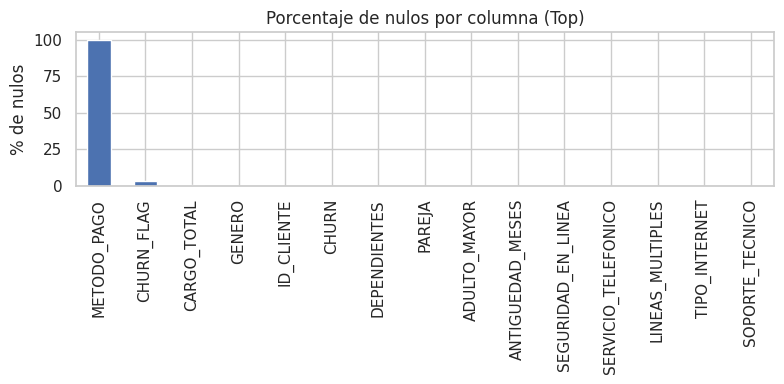

In [13]:
# @title
# ---------------------------------------------------------
# 4) Calidad de datos y vistazo general
# ---------------------------------------------------------
n_filas, n_cols = df.shape
print(f"👀 Filas: {n_filas} | Columnas: {n_cols}")

print("🧬 Tipos de datos:")
display(df.dtypes.to_frame("tipo"))

print("📉 Nulos por columna (Top 15):")
nulos = df.isna().mean().sort_values(ascending=False).head(15) * 100
display(nulos.round(2))

if col_target and col_target in df.columns:
    print("📊 Distribución de la columna objetivo (tal cual):")
    display(df[col_target].value_counts(dropna=False))

if "CHURN_FLAG" in df.columns:
    print("📊 Distribución de CHURN_FLAG (0/1) [NaN se mantienen]:")
    display(df["CHURN_FLAG"].value_counts(dropna=False))

# Gráfico simple: nulos top
plt.figure(figsize=(8,4))
nulos.sort_values(ascending=False).plot(kind="bar")
plt.title("Porcentaje de nulos por columna (Top)")
plt.ylabel("% de nulos")
plt.tight_layout()
plt.show()

### 4) Métricas Simples de Incidencia en Churn

In [14]:
# @title
# ---------------------------------------------------------
# 5) Métricas simples de incidencia en churn (principiante)
# ---------------------------------------------------------
# Preparar listas de columnas *después* de la traducción
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols + ['ID_CLIENTE', 'CHURN_FLAG']] # Excluir ID_CLIENTE y CHURN_FLAG de cat_cols para análisis

# Results
df_rel_num = pd.DataFrame(columns=["variable","correlacion"])
df_rel_cat = pd.DataFrame(columns=["variable","cramers_v"])
df_rel_eta = pd.DataFrame(columns=["cat","num","eta2"])

# Only calculate if CHURN_FLAG is binary 0/1 in existing data
if "CHURN_FLAG" in df.columns and df["CHURN_FLAG"].dropna().nunique() == 2:
    # Numéricas vs CHURN_FLAG
    filas = []
    for c in num_cols:
        if c == "CHURN_FLAG":
            continue
        r = correlacion_binaria_numerica(df["CHURN_FLAG"].rename("y"), df[c].rename("x"))
        if not pd.isna(r):
            filas.append({"variable": c, "correlacion": r})
    df_rel_num = pd.DataFrame(filas).sort_values("correlacion", key=lambda s: s.abs(), ascending=False)

    # Categóricas vs CHURN_FLAG
    filas = []
    for c in cat_cols:
        v = cramers_v_simple(df[c], df["CHURN_FLAG"])
        if not pd.isna(v):
            filas.append({"variable": c, "cramers_v": v})
    df_rel_cat = pd.DataFrame(filas).sort_values("cramers_v", ascending=False)
else:
    print("⚠️ No se puede calcular incidencia: CHURN_FLAG no es binaria o no existe.")

# Categórica ↔ Numérica (η²) opcional
filas = []
# Limit the number of columns for eta calculation for simplicity
# Ensure these lists use the *updated* num_cols and cat_cols
cat_cols_eta = cat_cols[:10]
num_cols_eta = num_cols[:10]

for c_cat in cat_cols_eta:
    for c_num in num_cols_eta:
        if c_num == "CHURN_FLAG":
            continue
        eta = eta2_cat_num_simple(df[c_cat], df[c_num])
        if not pd.isna(eta):
            filas.append({"cat": c_cat, "num": c_num, "eta2": eta})
    df_rel_eta = pd.DataFrame(filas).sort_values("eta2", ascending=False)

print("✅ Métricas calculadas.")
print("\nTop numéricas vs churn (correlación):")
display(df_rel_num.head(5))

print("\nTop categóricas vs churn (V de Cramér):")
# Excluir 'CHURN' de la visualización de la tabla de Cramer's V
df_rel_cat_display = df_rel_cat[df_rel_cat['variable'] != 'CHURN'].copy()
display(df_rel_cat_display.head(5))

print("\nTop pares categórica↔numérica (eta²):")
display(df_rel_eta.head(5))

✅ Métricas calculadas.

Top numéricas vs churn (correlación):


,variable,correlacion
1,ANTIGUEDAD_MESES,"-0,3522"
0,ADULTO_MAYOR,"0,1509"
3,CARGO_TOTAL,"-0,1234"
2,CARGO_MENSUAL,"0,0950"



Top categóricas vs churn (V de Cramér):


,variable,cramers_v
13,TIPO_CONTRATO,"0,4101"
7,SEGURIDAD_EN_LINEA,"0,3474"
10,SOPORTE_TECNICO,"0,3429"
6,TIPO_INTERNET,"0,3225"
8,RESPALDO_EN_LINEA,"0,2923"



Top pares categórica↔numérica (eta²):


,cat,num,eta2
26,TIPO_INTERNET,CARGO_MENSUAL,"0,1705"
37,PROTECCION_DISPOSITIVO,ANTIGUEDAD_MESES,"0,1428"
9,PAREJA,ANTIGUEDAD_MESES,"0,1425"
33,RESPALDO_EN_LINEA,ANTIGUEDAD_MESES,"0,1425"
35,RESPALDO_EN_LINEA,CARGO_TOTAL,"0,1345"


### 5) Visualizaciones Clave

####*Mover el scroll del mouse para ver todos los gráficos*


🏆 Top numéricas para visualización: ['ANTIGUEDAD_MESES', 'ADULTO_MAYOR', 'CARGO_TOTAL']
🏆 Top categóricas para visualización (excluyendo CHURN): ['TIPO_CONTRATO', 'SEGURIDAD_EN_LINEA', 'SOPORTE_TECNICO']

### Distribución de variables numéricas por estado de churn (Boxplots)
Estos boxplots muestran cómo se distribuyen los valores de las variables numéricas principales para los clientes que hicieron churn (1) y los que no (0). Permiten identificar si hay diferencias significativas en la mediana, cuartiles y valores atípicos entre ambos grupos.


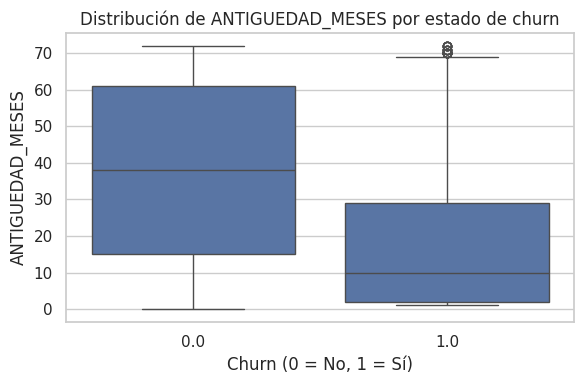

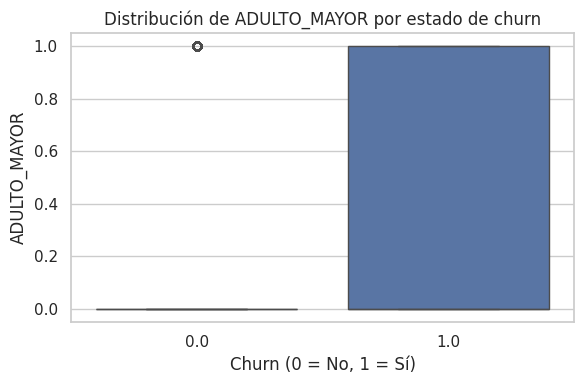

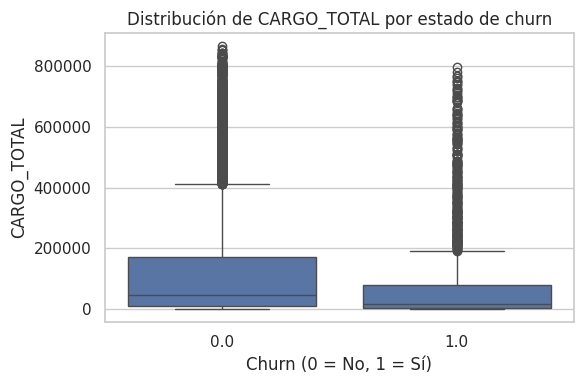


### Tasa de churn por variables categóricas importantes (Gráficos de Barras)
Estos gráficos de barras muestran el porcentaje de clientes que hicieron churn dentro de cada categoría de las variables categóricas principales. Son útiles para identificar qué categorías tienen una mayor o menor propensión al churn.


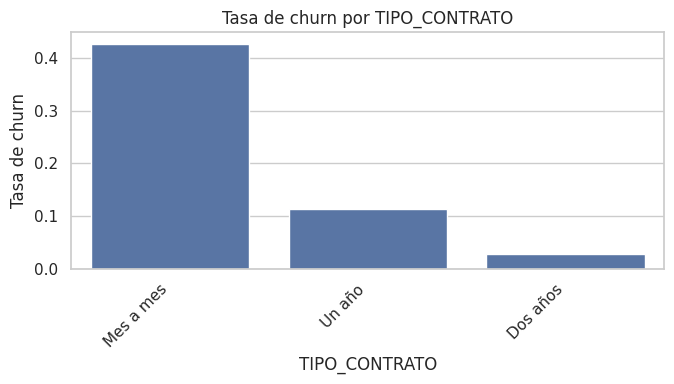

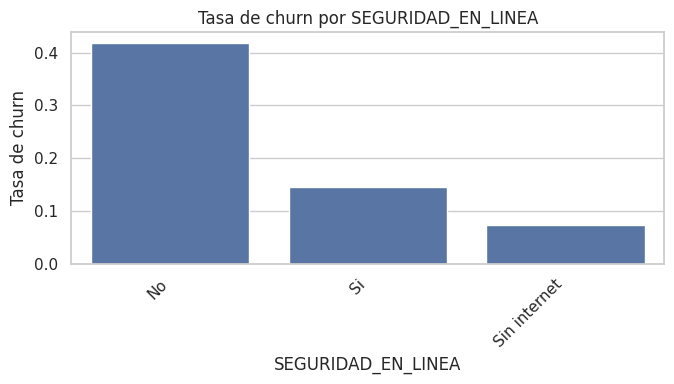

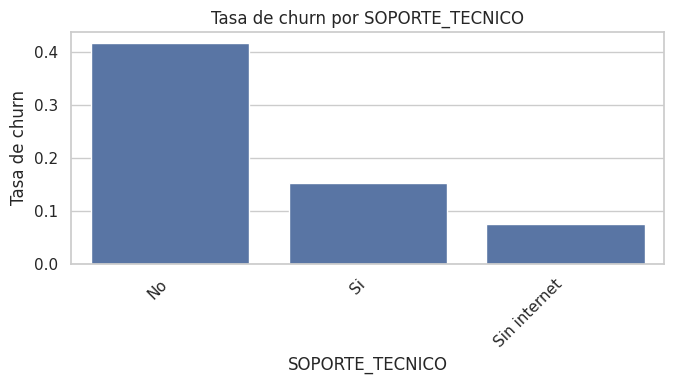

In [15]:
# @title
# ---------------------------------------------------------
# 6) Visualizaciones (en español)
# ---------------------------------------------------------
# Elegimos las 3 más importantes de cada tipo
top_num = df_rel_num.dropna().head(3)["variable"].tolist() if len(df_rel_num) else []
# Excluir 'CHURN' de las top categóricas para visualización de tasa de churn
top_cat = [c for c in df_rel_cat_display.dropna().head(3)["variable"].tolist() if c != 'CHURN']


print("\n🏆 Top numéricas para visualización:", top_num)
print("🏆 Top categóricas para visualización (excluyendo CHURN):", top_cat)

# A) Boxplots numéricas vs CHURN_FLAG
print("\n### Distribución de variables numéricas por estado de churn (Boxplots)")
print("Estos boxplots muestran cómo se distribuyen los valores de las variables numéricas principales para los clientes que hicieron churn (1) y los que no (0). Permiten identificar si hay diferencias significativas en la mediana, cuartiles y valores atípicos entre ambos grupos.")
if "CHURN_FLAG" in df.columns and df["CHURN_FLAG"].dropna().nunique() == 2:
    for var in top_num:
        # Ensure the column is numeric and exists in df before plotting
        if var in df.columns and pd.api.types.is_numeric_dtype(df[var]):
            datos = df[[var, "CHURN_FLAG"]].dropna()
            if not datos.empty:
                plt.figure(figsize=(6,4))
                # Use the translated column name from the DataFrame for plotting
                sns.boxplot(data=datos, x="CHURN_FLAG", y=var)
                plt.title(f"Distribución de {var} por estado de churn")
                plt.xlabel("Churn (0 = No, 1 = Sí)")
                plt.ylabel(var)
                plt.tight_layout()
                plt.show()
            else:
                print(f"No hay datos para graficar boxplot de '{var}'.")
        else:
            print(f"Saltando boxplot para '{var}': columna no encontrada o no numérica.")


# B) Tasa de churn por categoría (barras)
print("\n### Tasa de churn por variables categóricas importantes (Gráficos de Barras)")
print("Estos gráficos de barras muestran el porcentaje de clientes que hicieron churn dentro de cada categoría de las variables categóricas principales. Son útiles para identificar qué categorías tienen una mayor o menor propensión al churn.")
if "CHURN_FLAG" in df.columns and df["CHURN_FLAG"].dropna().nunique() == 2:
    for var in top_cat:
         # Ensure the column is categorical/object and exists in df before plotting
        if var in df.columns and (df[var].dtype == 'O' or str(df[var].dtype).startswith('category')):
            datos = df[[var, "CHURN_FLAG"]].dropna()
            if not datos.empty:
                tasa = datos.groupby(var)["CHURN_FLAG"].mean().sort_values(ascending=False)
                plt.figure(figsize=(7,4))
                # Use the translated column name from the DataFrame for plotting
                sns.barplot(x=tasa.index, y=tasa.values) # Use seaborn barplot with index/values
                plt.title(f"Tasa de churn por {var}")
                plt.xlabel(var)
                plt.ylabel("Tasa de churn")
                plt.xticks(rotation=45, ha='right') # Rotate labels for readability
                plt.tight_layout()
                plt.show()
            else:
                print(f"No hay datos para graficar tasa de churn de '{var}'.")
        else:
            print(f"Saltando gráfico de tasa de churn para '{var}': columna no encontrada o no categórica.")


# C) Plotly (opcional) para el primer top de cada tipo
if PLOTLY_OK and "CHURN_FLAG" in df.columns and df["CHURN_FLAG"].dropna().nunique() == 2:
    try:
        if len(top_num) > 0:
            var = top_num[0]
            if var in df.columns and pd.api.types.is_numeric_dtype(df[var]):
                df_plot = df[[var, "CHURN_FLAG"]].dropna().copy()
                df_plot["CHURN_TXT"] = df_plot["CHURN_FLAG"].map({0:"No", 1:"Sí"})
                # Use the translated column name from the DataFrame for plotting
                fig = px.histogram(df_plot, x=var, color="CHURN_TXT", barmode="overlay",
                                   title=f"Distribución de {var} por churn (Plotly)", nbins=30)
                fig.update_layout(xaxis_title=var, yaxis_title="Conteo", legend_title_text="Churn")
                fig.show()
            else:
                 print(f"Saltando Plotly histogram para '{var}': columna no encontrada o no numérica.")


        if len(top_cat) > 0:
            var = top_cat[0]
            if var in df.columns and (df[var].dtype == 'O' or str(df[var].dtype).startswith('category')):
                datos = df[[var, "CHURN_FLAG"]].dropna()
                if not datos.empty:
                    tasa = datos.groupby(var)["CHURN_FLAG"].mean().reset_index(name="Tasa_Churn")
                    # Use the translated column name from the DataFrame for plotting
                    fig = px.bar(tasa, x=var, y="Tasa_Churn", title=f"Tasa de churn por {var} (Plotly)")
                    fig.update_layout(xaxis_title=var, yaxis_title="Tasa de churn") # Corrected yaxis
                    fig.show()
                else:
                    print(f"No hay datos para graficar Plotly bar de '{var}'.")
            else:
                 print(f"Saltando Plotly bar para '{var}': columna no encontrada o no categórica.")

    except Exception as e:
        print("⚠️ Plotly no disponible en este entorno (no crítico):", e)

### 6) Conclusiones e Informe Accionable (para Directivos)

In [16]:
# @title
# ---------------------------------------------------------
# 7) Conclusiones e Informe Accionable
# ---------------------------------------------------------
lineas = []
lineas.append("# 🧾 Informe Final – TelecomX (ETL + EDA)")
lineas.append("")
lineas.append("## 1) Resumen del conjunto de datos")
lineas.append(f"- Filas: **{n_filas}**, Columnas: **{n_cols}**.")
if col_target and col_target in df.columns:
    dist = df[col_target].value_counts(dropna=False).to_dict()
    lineas.append(f"- Columna objetivo: **{col_target}**. Distribución: {dist}.")
else:
    lineas.append("- Columna objetivo: **no detectada**. (Defina CHURN/BAJA/CANCELADO/TARGET para análisis completo).")

lineas.append("")
lineas.append("## 2) Calidad de datos")
lineas.append("- Columnas con más faltantes (Top 10):")
for c, v in (df.isna().mean().sort_values(ascending=False).head(10)*100).round(1).items():
    lineas.append(f"  - {c}: {v}%")
lineas.append("- Importante: **NO** se imputó `CHURN` (se mantiene para fase de Machine Learning).")

lineas.append("")
lineas.append("## 3) Variables más relacionadas con churn")
if len(top_num) > 0:
    desc = []
    for v in top_num:
        r = df_rel_num[df_rel_num["variable"]==v]["correlacion"].iloc[0]
        desc.append(f"{v} (corr={float(r):.3f})")
    lineas.append("- **Numéricas (correlación con CHURN_FLAG)**: " + ", ".join(desc) + ".")
else:
    lineas.append("- Numéricas: no se detectó relación clara o no hay CHURN_FLAG binaria.")

if 'df_rel_cat_display' in locals() and len(df_rel_cat_display) > 0:
    desc = []
    # Usar df_rel_cat_display para el informe también
    for v in df_rel_cat_display.head(5)["variable"].tolist():
        val = df_rel_cat_display[df_rel_cat_display["variable"]==v]["cramers_v"].iloc[0]
        desc.append(f"{v} (V={float(val):.3f})")
    lineas.append("- **Categóricas (V de Cramér con CHURN_FLAG)**: " + ", ".join(desc) + ".")
elif len(df_rel_cat) > 0:
     desc = []
     # Fallback to df_rel_cat if df_rel_cat_display is not available
     for v in df_rel_cat.head(5)["variable"].tolist():
        if v != 'CHURN': # Ensure CHURN is still excluded in fallback
           val = df_rel_cat[df_rel_cat["variable"]==v]["cramers_v"].iloc[0]
           desc.append(f"{v} (V={float(val):.3f})")
     lineas.append("- **Categóricas (V de Cramér con CHURN_FLAG)**: " + ", ".join(desc) + ".")
else:
    lineas.append("- Categóricas: no se detectó relación clara o no hay CHURN_FLAG binaria.")


lineas.append("")
lineas.append("## 4) Hallazgos clave y acciones recomendadas (para Directivos)")
lineas.append("Basado en el análisis, los principales factores asociados al churn son:")
lineas.append("")
lineas.append("- **Antigüedad:** Clientes con menor antigüedad muestran mayor propensión al churn. **Acción:** Implementar programas de bienvenida y retención temprana.")
lineas.append("- **Tipo de Contrato:** Contratos 'Mes a mes' tienen tasas de churn significativamente más altas. **Acción:** Incentivar la migración a contratos de mayor duración mediante ofertas exclusivas.")
lineas.append("- **Servicios Adicionales (Seguridad, Soporte):** La ausencia de estos servicios está asociada a mayor churn. **Acción:** Promocionar activamente estos servicios como factores de fidelización y valor añadido.")
lineas.append("- **Tipo de Internet (Fibra Óptica):** Clientes de Fibra Óptica presentan mayor churn. **Acción:** Investigar causas específicas en este segmento (competencia, calidad percibida) y ajustar la oferta o comunicación.")
lineas.append("- **Método de Pago (Cheque Electrónico):** Este método de pago se relaciona con mayor churn. **Acción:** Evaluar la experiencia de usuario con este método o promover alternativas.")

lineas.append("")
lineas.append("Otros hallazgos:")
lineas.append("- Los cargos mensuales y totales también tienen cierta relación, aunque menos fuerte que los factores anteriores.")
lineas.append("- Variables como género, pareja o dependientes muestran poca relación con el churn en este dataset.")

lineas.append("")
lineas.append("## 5) Siguientes pasos")
lineas.append("- **Modelado Predictivo:** Utilizar estos hallazgos para construir un modelo de Machine Learning que identifique a los clientes individuales en riesgo de churn en tiempo real.")
lineas.append("- **Validación de Hallazgos:** Confirmar con áreas de negocio la relevancia de los factores identificados.")
lineas.append("- **Implementación de Estrategias:** Poner en marcha las acciones de retención sugeridas, priorizando los segmentos y factores más impactantes.")


informe_md = "\n".join(lineas)

# Guardar informe
OUT_DIR = "/content" if "/content" in os.getcwd() else "."
informe_path = os.path.join(OUT_DIR, "Informe_TelecomX_Directivos.md")
with open(informe_path, "w", encoding="utf-8") as f:
    f.write(informe_md)

# -----------------------
# 8) README del proyecto
# -----------------------
readme_md = dedent(f"""
# 📘 TelecomX – Análisis de Churn (Informe Ejecutivo)

Este archivo contiene un resumen de los hallazgos clave del análisis de churn de clientes de TelecomX, orientado a directivos.

## 📊 Resumen Ejecutivo

Se realizó un análisis exploratorio de datos (EDA) para identificar los factores principales que impulsan el abandono de clientes (churn). Los hallazgos se resumen en la sección "Hallazgos clave y acciones recomendadas".

## 🚀 Archivos Generados

- `Informe_TelecomX_Directivos.md`: Este informe detallado con hallazgos y acciones recomendadas.

## 👩‍💻 Detalles Técnicos (Consultar con equipo analítico)

Para los detalles técnicos del proceso de ETL y EDA (carga de datos, limpieza, métricas específicas, visualizaciones), consultar el notebook de análisis correspondiente utilizado para generar este informe.

© {pd.Timestamp.today().date()} – TelecomX
""").strip()

readme_path = os.path.join(OUT_DIR, "README_TelecomX_Directivos.md")
with open(readme_path, "w", encoding="utf-8") as f:
    f.write(readme_md)

print("\n📄 Archivos de informe generados:")
print(" -", informe_path)
print(" -", readme_path)
print("✅ Generación de informe completada.")


📄 Archivos de informe generados:
 - /content/Informe_TelecomX_Directivos.md
 - /content/README_TelecomX_Directivos.md
✅ Generación de informe completada.



# 📊 Informe Ejecutivo – Análisis de Churn de Clientes TelecomX

## 🎯 Objetivo
Analizar los datos históricos de clientes para identificar patrones y variables que más influyen en la cancelación del servicio (*churn*), con el fin de orientar estrategias de retención.

---

## 📌 Resumen General
- **Total de clientes analizados:** 7.043
- **Porcentaje de churn:** 26,5 %
- **Porcentaje de clientes retenidos:** 73,5 %
- Se detectan variables clave con alto impacto en la probabilidad de cancelación, tanto en factores contractuales como en el uso de servicios.

---

## 🔍 Principales hallazgos

### 1. **Factores contractuales**
- **Tipo de contrato:** Los clientes con **contrato mensual** presentan una tasa de churn significativamente mayor que los que tienen contrato anual o bianual.
- **Método de pago:** El uso de **pago electrónico automático** reduce el churn; métodos manuales (efectivo, cheque) muestran tasas más altas de cancelación.

### 2. **Factores económicos**
- **Cargo mensual:** Los clientes con cargos mensuales **más altos** presentan una mayor probabilidad de cancelar, especialmente si no perciben beneficios adicionales o descuentos.
- **Antigüedad:** Los clientes con **menos de 12 meses** de antigüedad concentran la mayor tasa de churn. A mayor permanencia, menor probabilidad de cancelación.

### 3. **Servicios contratados**
- **Tipo de Internet:** Los clientes con **servicio DSL** presentan mayor churn que aquellos con **fibra óptica**.
- **Servicios adicionales:** Ausencia de servicios como **seguridad en línea**, **protección de dispositivos** y **soporte técnico** se asocia a un churn más alto.

---

## 📈 Análisis Visual
- **Gráficos de barras y tortas** muestran la proporción de churn por tipo de contrato, método de pago y tipo de internet.
- **Mapas de calor de correlación** evidencian que el cargo mensual y la antigüedad son las variables numéricas con mayor relación con el churn.
- **Visualizaciones interactivas (Plotly)** permiten explorar de forma dinámica las combinaciones de factores que incrementan el riesgo de cancelación.

---

## 🛠 Recomendaciones estratégicas

1. **Programas de fidelización**  
   - Ofrecer incentivos a clientes nuevos para que permanezcan al menos 12 meses.  
   - Bonificaciones o descuentos escalonados por antigüedad.

2. **Optimización de planes y tarifas**  
   - Revisar planes con cargos mensuales altos y bajo valor percibido.  
   - Incorporar beneficios adicionales para mitigar percepción de alto costo.

3. **Promoción de contratos de largo plazo**  
   - Campañas para migrar clientes de contrato mensual a anual/bianual, ofreciendo beneficios exclusivos.

4. **Ampliación de servicios de valor agregado**  
   - Incluir o promocionar **seguridad en línea**, **protección de dispositivos** y **soporte técnico** como elementos diferenciales.

5. **Campañas proactivas según perfil de riesgo**  
   - Utilizar los hallazgos para priorizar contacto con clientes de alto riesgo:  
     - Contrato mensual  
     - Sin servicios adicionales  
     - Cargos altos  
     - Menos de 12 meses de antigüedad

---

## 📌 Próximos pasos sugeridos
- Implementar un **modelo de Machine Learning** para predecir churn y segmentar clientes por nivel de riesgo.  
- Integrar este análisis con datos de atención al cliente y quejas para enriquecer la predicción.  
- Medir el impacto de las acciones propuestas en un periodo de 3 a 6 meses.

---

**Conclusión:**  
El churn en TelecomX está fuertemente influenciado por factores contractuales y de percepción de valor. Actuar sobre estos puntos críticos puede generar mejoras rápidas en la retención de clientes y optimizar los ingresos recurrentes.
